In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
data = datasets.load_boston()
X = torch.tensor(data['data'], dtype=torch.float32)
y = torch.tensor(data['target'], dtype=torch.float32)
N, F = X.shape

# Frequentist

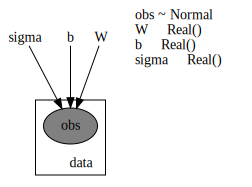

In [4]:
class FrequentistModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroParam(torch.randn(F))
        self.b = pyro.nn.PyroParam(torch.ones(1))
        self.sigma = pyro.nn.PyroParam(torch.ones(1), constraint=constraints.positive)

    def forward(self, X, y=None):
        mean = X @ self.W + self.b
        sigma = self.sigma

        with pyro.plate("data", len(X)):
            return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

model = FrequentistModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [5]:
for i in range(3):
    print(model(X)[:5])

tensor([195.4950, 240.9778, 232.8126, 237.7740, 241.7150],
       grad_fn=<SliceBackward0>)
tensor([196.2750, 241.8736, 232.5008, 238.9839, 242.0698],
       grad_fn=<SliceBackward0>)
tensor([194.8715, 238.8998, 234.5106, 241.1586, 241.9142],
       grad_fn=<SliceBackward0>)


In [6]:
dist.Normal(0, 1).expand([F]).sample()

tensor([ 0.2848, -0.2884, -1.2490,  0.7589, -2.9202,  0.2145, -0.4321, -0.8833,
         0.2931, -0.8486,  0.4614,  0.3781,  1.0547])

# Bayesian

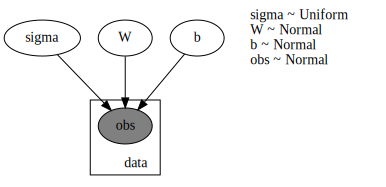

In [7]:
class BayesianModel(pyro.nn.PyroModule):
    
    def __init__(self):
        super().__init__()
        self.W = pyro.nn.PyroSample(dist.Normal(0, 10).expand([F]).to_event(1))
        self.b = pyro.nn.PyroSample(dist.Normal(20, 10))
        self.sigma = pyro.nn.PyroSample(dist.Uniform(0, 10))

    def forward(self, X, y=None):
        sigma = self.sigma   
        mean = X @ self.W + self.b
        
        with pyro.plate("data", N):
            return pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

model = BayesianModel()
pyro.render_model(model, model_args=(X, y), render_distributions=True, render_params=True)

In [8]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

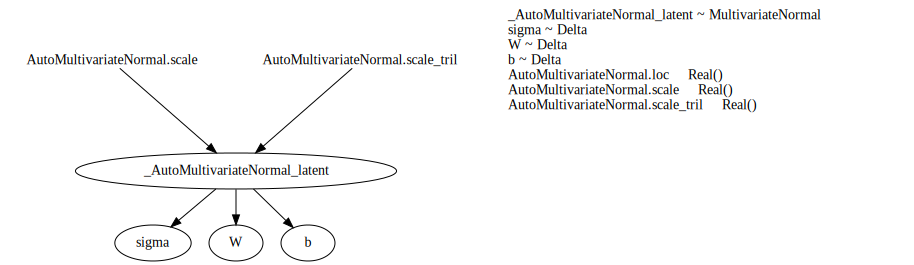

In [9]:
pyro.render_model(guide, model_args=(X, y), render_distributions=True, render_params=True)

In [10]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title(f'Min loss: {min(losses)}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

# Training - SVI

In [11]:
pyro.util.set_rng_seed(42)

guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

losses = []
for i in range(10_000):
    loss = svi.step(X, y)
    losses.append(loss)

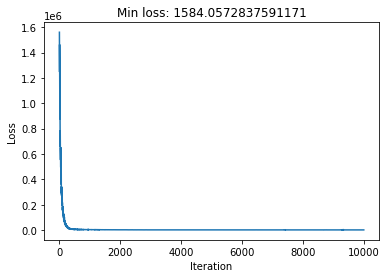

In [12]:
plot_losses(losses)

In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

W [ 0.3870844  -0.6069255   0.95718926  0.9853127  -0.41052887  0.4604355
 -0.05804207 -1.1337019  -0.7117924  -0.5454541  -0.7495043   0.9554555
  0.8397433 ]
b [1.]
sigma [1.]
AutoMultivariateNormal.loc [ 2.4230605e-01 -1.0923546e-01  4.1277815e-02 -3.7670244e-02
  2.6216226e+00 -4.1612802e+00  3.9639716e+00 -1.0241009e-02
 -1.2637550e+00  2.6424742e-01 -1.5330478e-02 -7.6178128e-01
  8.8922512e-03 -5.4642606e-01  2.5324472e+01]
AutoMultivariateNormal.scale [0.10636509 0.03820533 0.01707198 0.05529241 0.99317986 1.0054239
 0.08903088 0.00755077 0.07273258 0.03373638 0.00275186 0.01960429
 0.00368945 0.01493737 0.19195299]
AutoMultivariateNormal.scale_tril [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.83798853e-02  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  

In [14]:
with pyro.plate('samples', 1_000, dim=-1):
    samples = guide(X)

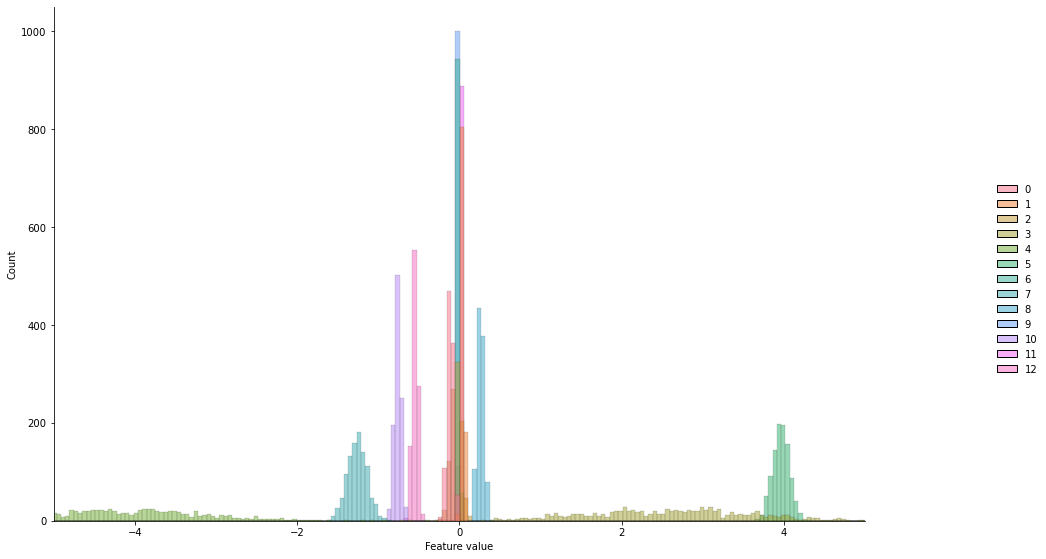

In [15]:
w = samples['W'].detach().numpy()
g = sns.displot(w)
g.fig.set_figheight(8)
g.fig.set_figwidth(16)
plt.xlabel('Feature value')
plt.xlim(-5, 5);

In [16]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)
svi_samples = predictive(X)
svi_y = svi_samples["obs"]

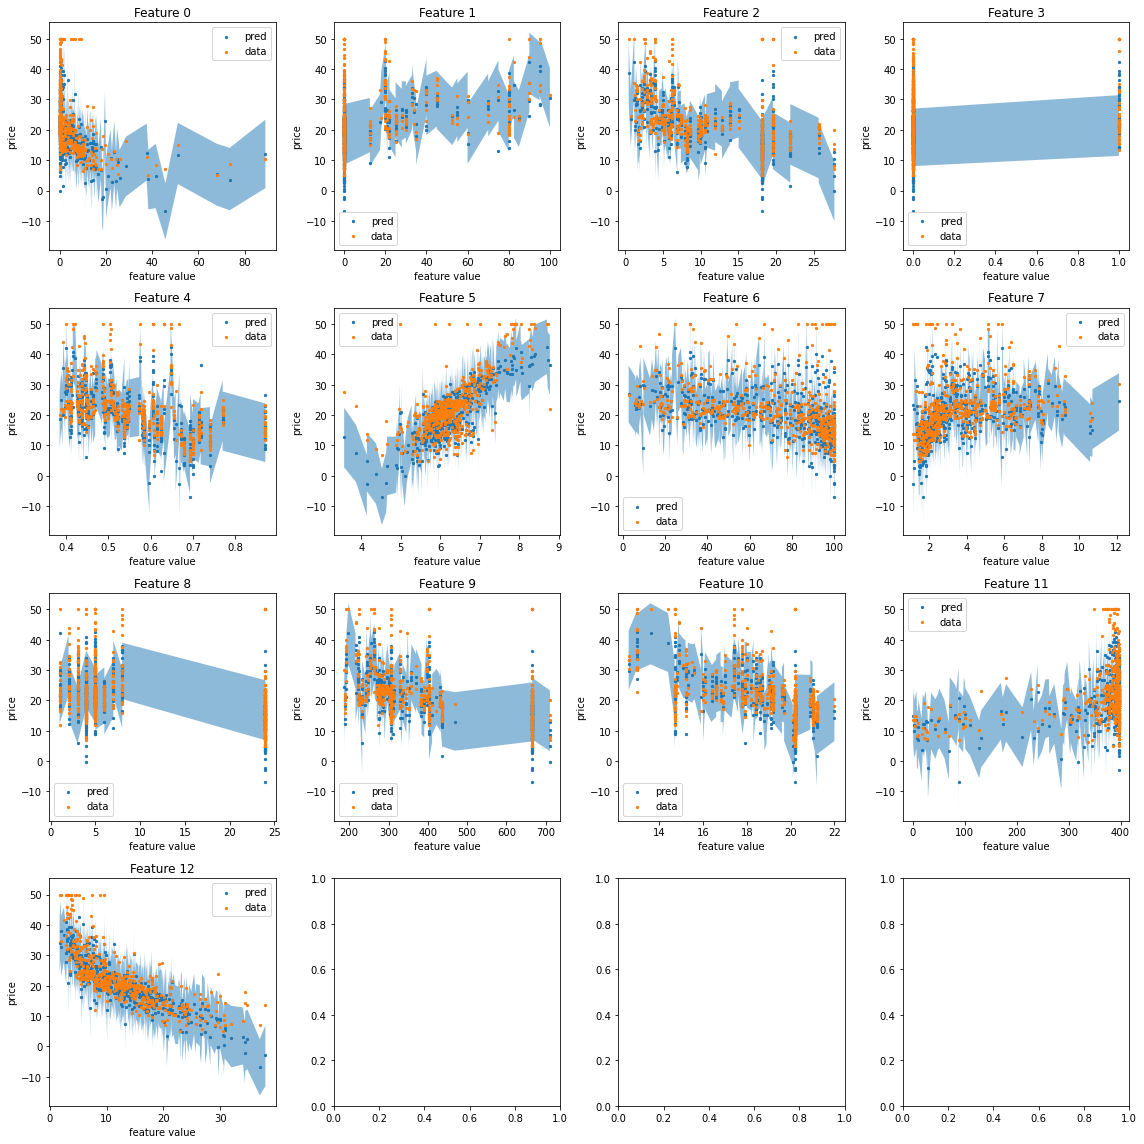

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i in range(F):
    preds = pd.DataFrame({
        'X': X[:, i],
        'y_mean': svi_y.mean(0).detach().cpu().numpy(),
        'y_perc_5': svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
        'y_perc_95': svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
        'true_y': y,
    }).sort_values('X')
    ax = axes[i // 4][i % 4]
    ax.scatter(preds['X'], preds['y_mean'], s=5, label='pred', c='C0')
    ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
    ax.scatter(preds['X'], preds['true_y'], s=5, label='data', c='C1')
    ax.set_title(f'Feature {i}')
    ax.set_ylabel('price')
    ax.set_xlabel('feature value')
    ax.legend()
plt.tight_layout()

# Training - MCMC

In [18]:
pyro.clear_param_store()
model = BayesianModel()

In [19]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

pyro.util.set_rng_seed(42)

nuts_kernel = NUTS(model, jit_compile=True, step_size=1e-5)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=100, num_chains=5)
mcmc.run(X, y)

Warmup [1]:   0%|          | 0/300 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/300 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/300 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/300 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/300 [00:00, ?it/s]

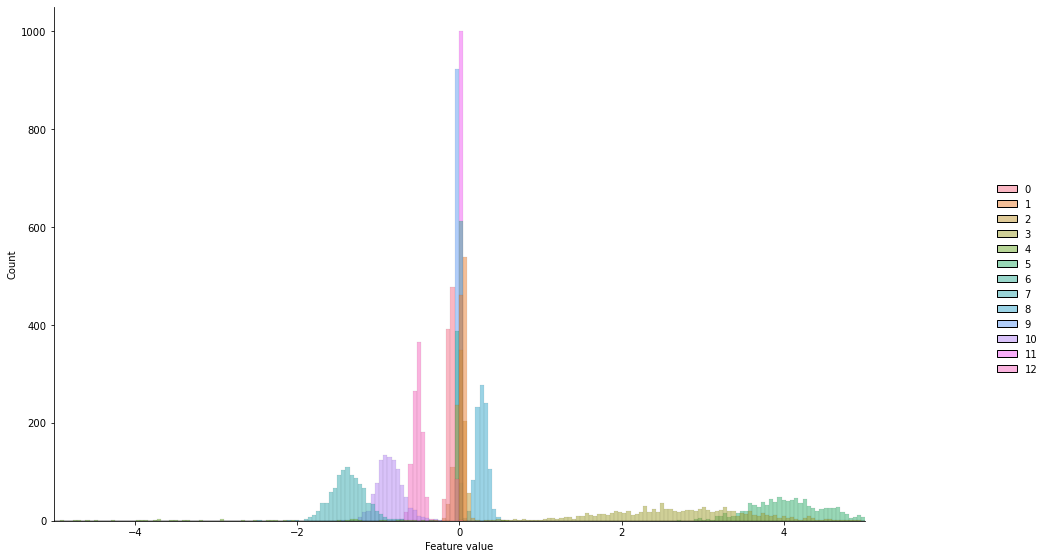

In [20]:
w = mcmc.get_samples()['W']
g = sns.displot(w)
g.fig.set_figheight(8)
g.fig.set_figwidth(16)
plt.xlabel('Feature value')
plt.xlim(-5, 5);

In [21]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1_000)
mcmc_samples = predictive(X)
mcmc_y = mcmc_samples["obs"]

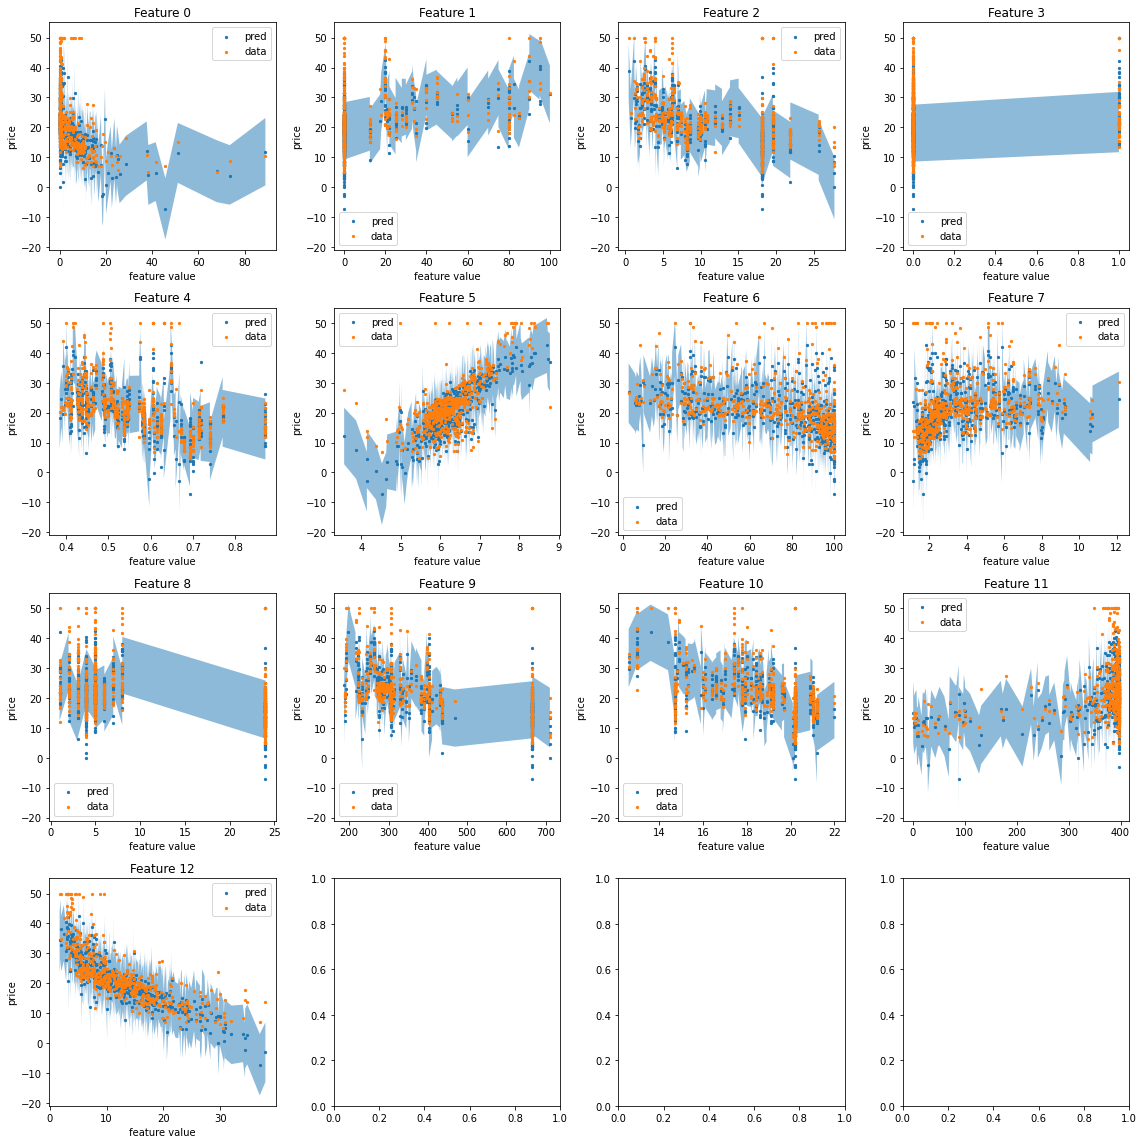

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i in range(F):
    preds = pd.DataFrame({
        'X': X[:, i],
        'y_mean': mcmc_y.mean(0).detach().cpu().numpy(),
        'y_perc_5': mcmc_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().numpy(),
        'y_perc_95': mcmc_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().numpy(),
        'true_y': y,
    }).sort_values('X')
    ax = axes[i // 4][i % 4]
    ax.scatter(preds['X'], preds['y_mean'], s=5, label='pred', c='C0')
    ax.fill_between(preds['X'], preds['y_perc_5'], preds['y_perc_95'], alpha=0.5)
    ax.scatter(preds['X'], preds['true_y'], s=5, label='data', c='C1')
    ax.set_title(f'Feature {i}')
    ax.set_ylabel('price')
    ax.set_xlabel('feature value')
    ax.legend()
plt.tight_layout()

# Deploy

In [23]:
model.eval()
trace = torch.jit.trace(model, X)

In [24]:
print(trace.code)

def forward(self,
    X: Tensor) -> Tensor:
  rand = torch.rand(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _0 = torch.mul(rand, torch.sub(CONSTANTS.c0, CONSTANTS.c1))
  _1 = torch.add(CONSTANTS.c1, _0)
  _2 = torch.zeros([13], dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _3 = torch.ones([13], dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  eps = torch.normal(_2, _3)
  _4 = torch.add(CONSTANTS.c3, torch.mul(eps, CONSTANTS.c2))
  _5 = torch.matmul(X, _4)
  _6 = torch.zeros(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  _7 = torch.ones(annotate(List[int], []), dtype=6, layout=None, device=torch.device("cpu"), pin_memory=False)
  eps0 = torch.normal(_6, _7)
  _8 = torch.add(CONSTANTS.c4, torch.mul(eps0, CONSTANTS.c0))
  _9 = torch.add(_5, _8)
  subsample = torch.arange(506, dtype=None, layout=0, device=torch.device("cpu"), pin_memory=False)
  _1